In [1]:
import numpy as np
from numpy.random import randint
from IPython.display import clear_output
%matplotlib inline
from matplotlib import pyplot as plt

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import backend as K

Using TensorFlow backend.


In [9]:
import pyglet
from pyglet import app
from pyglet.window import Window, mouse, key
from pyglet import gl

In [562]:
# env
class Env(object):
    def __init__(self, r, c, vis_r):
        self.vis_r = vis_r #radius of snake vision
        self.r = r
        self.c = c
        
        vis2 = self.vis_r*2
        
        self.state = np.zeros((r, c, 3))
        self.state_padded = np.zeros((r+vis2, c+vis2, 3))
        self.define_model()
        self.reset()
        
    def reset(self, random_length=True):
        self.p = [randint(1, self.r-2), randint(1, self.c-2)]
        self.f = [randint(1, self.r-2), randint(1, self.c-2)]
        self.tail = []
        if random_length:
            self.length = np.random.randint(0, self.r*self.c-2*self.r-2*self.c)
        else:
            self.length = 0
        self.dir = 0 # direction
        self.step_count = 0
        self.end = False
        
        self.draw()
        
    def define_model(self):
        img_rows, img_cols = self.vis_r*2, self.vis_r*2
        
        input_shape = None
        if K.image_data_format() == 'channels_first':
            input_shape = (3, img_rows, img_cols)
        else:
            input_shape = (img_rows, img_cols, 3)
        
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        #self.model.add(Dropout(0.20))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        #self.model.add(Dropout(0.20))
        self.model.add(Dense(4, activation='softmax'))
        
        self.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=1.0),
              metrics=['accuracy'])
        
    def randomize_model(self):
        # https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in self.model.layers: 
            for v in layer.__dict__:
                v_arg = getattr(layer,v)
                if hasattr(v_arg,'initializer'):
                    initializer_method = getattr(v_arg, 'initializer')
                    initializer_method.run(session=session)
    
    def is_fail(self, p):
        if p[0] < 0 or p[0] > self.r-1 or p[1] < 0 or p[1] > self.c-1:
            return True
        return self.state[p[0], p[1], 1] == 1 # body
    
    def is_food(self, p):
        return p[0] == self.f[0] and p[1] == self.f[1]
    
    def draw(self):
        self.state[:] = 0
        
        #draw walls
        self.state[:,0,1] = 1
        self.state[:,self.c-1,1] = 1
        
        self.state[0,:,1] = 1
        self.state[self.r-1,:,1] = 1

        # draw tail
        for b in self.tail:
            self.state[b[0], b[1], 1] = 1
        
        # draw head and food
        self.state[self.p[0], self.p[1], 0] = 1
        self.state[self.f[0], self.f[1], 2] = 1
        
    def step(self, explore=1.0):
        _reward = 1 # if you survive
        
        self.step_count += 1
        if self.step_count > 100: # max steps
            self.end = True
            return (None, None, 0)
        
        self.state_padded[self.vis_r:self.vis_r+self.r,
                          self.vis_r:self.vis_r+self.c] = self.state
        
        r, c = self.p[0]+self.vis_r, self.p[1]+self.vis_r # offset
        _state = self.state_padded[r-self.vis_r:r+self.vis_r, c-self.vis_r:c+self.vis_r].reshape(1, self.vis_r*2, self.vis_r*2, 3)
        _state = _state.copy()
        
        _action = None
        if np.random.random() < explore:
            _action = np.random.choice([0,1,2,3])
        else:
            dist = self.model.predict(_state)
            _action = np.argmax(dist)
            
        self.dir = _action

        newp = [self.p[0], self.p[1]]
        if self.dir == 0: #up
            newp[1] += 1
        if self.dir == 1: #right
            newp[0] += 1
        if self.dir == 2: #down
            newp[1] -= 1
        if self.dir == 3: #left
            newp[0] -= 1
            
        if self.is_food(newp):
            _reward = 2
            #grow and move food
            self.length += 1
            
            self.f = [randint(1, self.r-2), randint(1, self.c-2)]
            while self.state[self.f[0], self.f[1], 1] == 1 or self.state[self.f[0], self.f[1] , 0] == 1:
                self.f = [randint(1, self.r-2), randint(1, self.c-2)]

        elif self.is_fail(newp):
            self.end = True
            return (None, None, 0)    
                
        # move to new position
        self.p = newp
            
        self.draw()
        
        # manage tail
        self.tail.insert(0, np.copy(self.p))
        if len(self.tail) > self.length:
            self.tail.pop()
        
        return (_state, _action, _reward) #sar

In [563]:
# create environment

env = Env(r=13, c=13, vis_r=7)
x_train, y_train = [], []

In [588]:
x_train, y_train = [], []

In [627]:
# gather some training data, then train it

for i in range(1000):
    if i % 100 == 0:
        print(i)
        
    session = []
    while not env.end:
        sar = env.step(explore=.2)
        session.append(sar)
        
        #if sar[2] == 1: # 1 survived, 2 food
        #    x_train.append(sar[0])
        #    action = np.zeros((1, 4))
        #    action[0, sar[1]] = 1
        #    y_train.append(action)
        
        if sar[2] == 2: # 1 survived, 2 food
            for s in session:
                x_train.append(s[0])
                action = np.zeros((1, 4))
                action[0, s[1]] = 1
                y_train.append(action)
            
    env.reset(random_length=True)

0
100
200
300
400
500
600
700
800
900


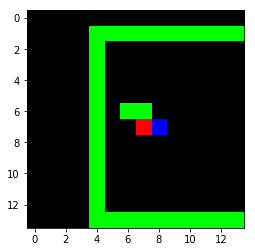

In [641]:
ri = np.random.choice(range(len(x_train)))
img = x_train[ri].reshape(env.vis_r*2, env.vis_r*2,3)
fig = plt.imshow(img)

In [642]:
_x_train = np.vstack(x_train)
_y_train = np.vstack(y_train)
env.model.fit(_x_train, _y_train, epochs=1, verbose=1)

Epoch 1/1
44747/44747 [==============================] - 11s - loss: 0.6159 - acc: 0.8070    


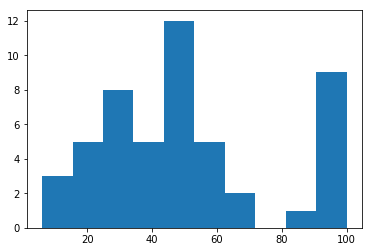

In [643]:
# run after training

rewards = []
for i in range(50):
    total_r = 0
    while not env.end:
        sar = env.step(explore=0)
        if sar[2] > 0:
            total_r += 1
    rewards.append(total_r)
    env.reset()
    
fig = plt.hist(rewards)

In [579]:
# visualize agent

for i in range(5):
    while not env.end:
        env.step(explore=0)
        clear_output(wait=True)
        plt.imshow(env.state, cmap=plt.cm.rainbow, vmin=-1, vmax=1)
        plt.show()
    env.reset()

KeyboardInterrupt: 

In [644]:
# visualize pyglet
bw, bh = 20, 20
win_width, win_height = bw*env.c, bh*env.r

# create window and run display it
win = Window(width=win_width, height=win_height)

def draw_rect(x, y, w, h, color):
    pyglet.graphics.draw(6, gl.GL_TRIANGLES,
                    ('v2f', [x, y, 
                             x+w, y,
                             x+w, y+h, 
                             x, y, 
                             x, y+h, 
                             x+w, y+h]),
                    ('c4f', color * 6))
    

env.reset(random_length=False)    
running = True
while not win.has_exit:
    win.dispatch_events()
    
    while not env.end:
        env.step(explore=0)
        
        #render
        win.clear()
        for index, x in np.ndenumerate(env.state):
            if x != 0:
                # draw a rect
                c = [1,1,1,1]
                if index[2] == 1:
                    c = [.5,.5,.5,1]
                elif index[2] == 2:
                    c = [0,1,0,1]
                    
                draw_rect(index[0]*bw, index[1]*bh, bw, bh, c)
        
        win.flip()
        
    env.reset(random_length=True)
    
win.close()